# Multi-Objective Capacitated VRP (MOVRP) Problem Using Multi-Objective Evolutionary Algorithms (MOEAs)

### Global Functions

In [45]:
import math
import numpy as np

def parse_vrp_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Strip whitespace and filter empty lines
    lines = [line.strip() for line in lines if line.strip()]

    # Parse metadata
    metadata = {}
    i = 0
    while not lines[i].startswith('NODE_COORD_SECTION'):
        if ':' in lines[i]:
            key, value = lines[i].split(':', 1)
            metadata[key.strip()] = value.strip().strip('"')
        i += 1

    # Parse node coordinates (1-based in file, but we'll make 0-based list)
    coords = []
    i += 1  # Skip section header
    while not lines[i].startswith('DEMAND_SECTION'):
        parts = lines[i].split()
        if len(parts) == 3:
            node_id = int(parts[0]) - 1  # Make 0-based
            x, y = int(parts[1]), int(parts[2])
            # Insert at correct index in case not sequential (though they usually are)
            while len(coords) <= node_id:
                coords.append(None)
            coords[node_id] = (x, y)
        i += 1

    # Parse demands (0-based list)
    demands = []
    i += 1  # Skip section header
    while not lines[i].startswith('DEPOT_SECTION'):
        parts = lines[i].split()
        if len(parts) == 2:
            node_id = int(parts[0]) - 1  # Make 0-based
            demand = int(parts[1])
            while len(demands) <= node_id:
                demands.append(None)
            demands[node_id] = demand
        i += 1

    # Parse depot(s) — usually just one, 1-based
    depots = []
    i += 1  # Skip section header
    while i < len(lines) and lines[i] != 'EOF':
        depot = int(lines[i])
        if depot == -1:
            break
        depots.append(depot - 1)  # Make 0-based
        i += 1

    # Compute distance matrix (Euclidean 2D)
    dimension = int(metadata.get('DIMENSION', len(coords)))
    dist_matrix = np.zeros((dimension, dimension))
    for a in range(dimension):
        for b in range(dimension):
            x1, y1 = coords[a]
            x2, y2 = coords[b]
            dist_matrix[a][b] = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    return {
        'metadata': metadata,
        'coords': coords,  # List of (x, y) tuples, 0-based (index 0 = node 1)
        'demands': demands,  # List of integers, 0-based
        'depots': depots,  # List of 0-based indices (usually [0] for depot at node 1)
        'dist_matrix': dist_matrix  # Numpy array of floats
    }

# Example usage for your files
small_data = parse_vrp_file('data/small.vrp')
medium_data = parse_vrp_file('data/medium.vrp')
large_data = parse_vrp_file('data/large.vrp')

# Print some extracted info from large (based on the provided sample)
print(large_data['metadata'])
print("Depot index:", large_data['depots'][0])
print("Sample coords (first 5):", large_data['coords'][:5])
print("Sample demands (first 5):", large_data['demands'][:5])
print("Sample distance (node 0 to 1):", large_data['dist_matrix'][0][1])

{'NAME': 'X-n101-k25', 'COMMENT': 'Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013)', 'TYPE': 'CVRP', 'DIMENSION': '101', 'EDGE_WEIGHT_TYPE': 'EUC_2D', 'CAPACITY': '206'}
Depot index: 0
Sample coords (first 5): [(365, 689), (146, 180), (792, 5), (658, 510), (461, 270)]
Sample demands (first 5): [0, 38, 51, 73, 70]
Sample distance (node 0 to 1): 554.1137067425782


## NSGA-II Implementation

In [46]:
import numpy as np
import random
import time

class NSGAII:
      def __init__(self, data, pop_size=20, generations=10, crossover_rate=0.7, mutation_rate=0.2):
          self.data = data
          self.pop_size = pop_size
          self.generations = generations
          self.crossover_rate = crossover_rate
          self.mutation_rate = mutation_rate
          self.population = []

          # Pre-compute frequently accessed values
          self.dist_matrix = self.data['dist_matrix']
          self.capacity = int(self.data['metadata']['CAPACITY'])
          self.demands = self.data['demands']
          self.n_customers = len(self.data['coords']) - 1
          self.customer_range = list(range(1, self.n_customers + 1))

      def split_routes(self, customer_sequence):
          """Route splitting with capacity constraints"""
          routes, route, load = [], [0], 0
          for customer in customer_sequence:
              demand = self.demands[customer]
              if load + demand > self.capacity:
                  route.append(0)
                  routes.append(route)
                  route, load = [0, customer], demand
              else:
                  route.append(customer)
                  load += demand
          route.append(0)
          routes.append(route)
          return routes

      def calculate_route_distance(self, route):
          """Calculate distance for a single route"""
          return sum(self.dist_matrix[route[i], route[i+1]] for i in range(len(route) - 1))

      def evaluate_objectives_fast(self, individual):
          """FIXED: Task-compliant objectives with better trade-off"""
          if individual['objectives'] is not None:
              return

          routes = individual['routes']
          route_distances = [self.calculate_route_distance(route) for route in routes]

          # Objective 1: Total Distance (minimize)
          total_dist = sum(route_distances)

          # Objective 2: Route Balance using Standard Deviation (creates better Pareto fronts)
          if len(route_distances) > 1:
              mean_length = total_dist / len(route_distances)
              variance = sum((d - mean_length)**2 for d in route_distances) / len(route_distances)
              route_balance = variance**0.5  # Standard deviation
          else:
              route_balance = 0.0

          individual['objectives'] = [total_dist, route_balance]

      def generate_initial_population(self):
          """Enhanced population with diverse initialization strategies"""
          population = []

          # Create solutions with different strategies for better diversity
          strategies = [
              self.nearest_neighbor_solution,     # Distance-focused
              self.balanced_insertion_solution,   # Balance-focused  
              self.random_solution,              # Random exploration
              self.capacity_focused_solution,    # Capacity-focused
          ]

          solutions_per_strategy = max(1, self.pop_size // len(strategies))

          for strategy in strategies:
              for _ in range(solutions_per_strategy):
                  try:
                      perm = strategy()
                      individual = {
                          'customer_sequence': perm,
                          'routes': self.split_routes(perm),
                          'objectives': None,
                          'rank': None,
                          'crowding_distance': 0.0
                      }
                      population.append(individual)
                  except:
                      # Fallback to random if strategy fails
                      perm = self.random_solution()
                      individual = {
                          'customer_sequence': perm,
                          'routes': self.split_routes(perm),
                          'objectives': None,
                          'rank': None,
                          'crowding_distance': 0.0
                      }
                      population.append(individual)

          # Fill remaining slots with random solutions
          while len(population) < self.pop_size:
              perm = self.random_solution()
              individual = {
                  'customer_sequence': perm,
                  'routes': self.split_routes(perm),
                  'objectives': None,
                  'rank': None,
                  'crowding_distance': 0.0
              }
              population.append(individual)

          return population[:self.pop_size]

      def nearest_neighbor_solution(self):
          """Distance-optimized solution"""
          unvisited = set(self.customer_range)
          solution = []
          current = 0

          while unvisited:
              distances = [(self.dist_matrix[current, customer], customer)
                          for customer in unvisited]
              _, next_customer = min(distances)
              solution.append(next_customer)
              unvisited.remove(next_customer)
              current = next_customer

          return solution

      def balanced_insertion_solution(self):
          """Balance-focused solution"""
          customers_by_distance = [(self.dist_matrix[0, c], c) for c in self.customer_range]
          customers_by_distance.sort()

          solution = []
          near = [c for _, c in customers_by_distance[:len(customers_by_distance)//2]]
          far = [c for _, c in customers_by_distance[len(customers_by_distance)//2:]]

          # Alternate between near and far customers
          for i in range(max(len(near), len(far))):
              if i < len(near):
                  solution.append(near[i])
              if i < len(far):
                  solution.append(far[i])

          return solution

      def random_solution(self):
          """Random solution"""
          solution = self.customer_range[:]
          random.shuffle(solution)
          return solution

      def capacity_focused_solution(self):
          """Capacity-optimized solution"""
          customers_by_demand = [(self.demands[c], c) for c in self.customer_range]
          customers_by_demand.sort(reverse=True)

          solution = [c for _, c in customers_by_demand]
          # Add some randomization
          mid = len(solution) // 2
          random.shuffle(solution[:mid])
          return solution

      def evaluate_objectives(self, population):
          """Evaluate all individuals"""
          for individual in population:
              self.evaluate_objectives_fast(individual)

      def fast_non_dominated_sort(self, population):
          """Non-dominated sorting"""
          n = len(population)
          objectives = [ind['objectives'] for ind in population]

          domination_count = [0] * n
          dominated_solutions = [[] for _ in range(n)]

          for i in range(n):
              obj1_i, obj2_i = objectives[i]
              for j in range(i + 1, n):
                  obj1_j, obj2_j = objectives[j]

                  # Check dominance
                  if (obj1_i <= obj1_j and obj2_i <= obj2_j) and (obj1_i < obj1_j or obj2_i < obj2_j):
                      dominated_solutions[i].append(j)
                      domination_count[j] += 1
                  elif (obj1_j <= obj1_i and obj2_j <= obj2_i) and (obj1_j < obj1_i or obj2_j < obj2_i):
                      dominated_solutions[j].append(i)
                      domination_count[i] += 1

          # Assign ranks
          current_front = [i for i in range(n) if domination_count[i] == 0]
          rank = 1

          for i in current_front:
              population[i]['rank'] = rank

          while current_front:
              next_front = []
              for i in current_front:
                  for j in dominated_solutions[i]:
                      domination_count[j] -= 1
                      if domination_count[j] == 0:
                          next_front.append(j)

              if next_front:
                  rank += 1
                  for i in next_front:
                      population[i]['rank'] = rank

              current_front = next_front

      def calculate_crowding_distance(self, population):
          """Calculate crowding distance"""
          for ind in population:
              ind['crowding_distance'] = 0.0

          rank_groups = {}
          for i, ind in enumerate(population):
              rank = ind['rank']
              if rank not in rank_groups:
                  rank_groups[rank] = []
              rank_groups[rank].append(i)

          for indices in rank_groups.values():
              n_front = len(indices)
              if n_front <= 2:
                  for i in indices:
                      population[i]['crowding_distance'] = float('inf')
                  continue

              for obj_idx in range(2):
                  indices.sort(key=lambda i: population[i]['objectives'][obj_idx])

                  population[indices[0]]['crowding_distance'] = float('inf')
                  population[indices[-1]]['crowding_distance'] = float('inf')

                  obj_range = population[indices[-1]]['objectives'][obj_idx] - population[indices[0]]['objectives'][obj_idx]

                  if obj_range > 0:
                      for j in range(1, n_front - 1):
                          i = indices[j]
                          if population[i]['crowding_distance'] != float('inf'):
                              prev_obj = population[indices[j-1]]['objectives'][obj_idx]
                              next_obj = population[indices[j+1]]['objectives'][obj_idx]
                              population[i]['crowding_distance'] += (next_obj - prev_obj) / obj_range

      def tournament_selection(self, population, tournament_size=2):
          """Tournament selection"""
          tournament = random.sample(population, tournament_size)
          return min(tournament, key=lambda x: (x['rank'], -x['crowding_distance']))

      def create_individual(self, customer_sequence):
          """Create individual from sequence"""
          return {
              'customer_sequence': customer_sequence,
              'routes': self.split_routes(customer_sequence),
              'objectives': None,
              'rank': None,
              'crowding_distance': 0.0
          }

      def pmx_crossover(self, parent1, parent2):
          """PMX crossover"""
          size = len(parent1['customer_sequence'])
          p1, p2 = parent1['customer_sequence'], parent2['customer_sequence']

          if size < 2:
              return self.create_individual(p1[:])

          start, end = sorted(random.sample(range(size), 2))
          child = [None] * size

          for i in range(start, end + 1):
              child[i] = p1[i]

          mapping = {p2[i]: p1[i] for i in range(start, end + 1) if p1[i] != p2[i]}

          for i in range(size):
              if child[i] is None:
                  gene = p2[i]
                  while gene in mapping:
                      gene = mapping[gene]

                  if gene in child:
                      available = set(self.customer_range) - set(g for g in child if g is not None)
                      gene = available.pop() if available else p2[i]

                  child[i] = gene

          return self.create_individual(child)

      def swap_mutation(self, individual):
          """Controlled mutation"""
          seq = individual['customer_sequence'][:]

          if random.random() < self.mutation_rate:
              # Simple swap mutation
              if len(seq) > 1:
                  i, j = random.sample(range(len(seq)), 2)
                  seq[i], seq[j] = seq[j], seq[i]

          return self.create_individual(seq)

      def run(self):
          """Main NSGA-II algorithm"""
          self.population = self.generate_initial_population()
          self.evaluate_objectives(self.population)
          self.fast_non_dominated_sort(self.population)
          self.calculate_crowding_distance(self.population)

          for gen in range(1, self.generations + 1):
              offspring = []

              for _ in range(self.pop_size):
                  parent1 = self.tournament_selection(self.population)
                  parent2 = self.tournament_selection(self.population)

                  if random.random() < self.crossover_rate:
                      child = self.pmx_crossover(parent1, parent2)
                  else:
                      child = self.create_individual(parent1['customer_sequence'][:])

                  child = self.swap_mutation(child)
                  offspring.append(child)

              self.evaluate_objectives(offspring)
              combined = self.population + offspring
              self.fast_non_dominated_sort(combined)
              self.calculate_crowding_distance(combined)
              combined.sort(key=lambda x: (x['rank'], -x['crowding_distance']))
              self.population = combined[:self.pop_size]

          return self.population

## SPEA2 Implementation

In [47]:
## TODO ADD ALGO

# Experiment

Clean NSGA-II Experiment - Assignment 2 Focus
FOCUSED NSGA-II EXPERIMENT - Clean Results

Parameter Set: Conservative
  Instance: Small... Complete - 76 solutions
  Instance: Medium... Complete - 67 solutions
  Instance: Large... Complete - 50 solutions

Parameter Set: Balanced
  Instance: Small... Complete - 44 solutions
  Instance: Medium... Complete - 57 solutions
  Instance: Large... Complete - 45 solutions

Parameter Set: Aggressive
  Instance: Small... Complete - 54 solutions
  Instance: Medium... Complete - 58 solutions
  Instance: Large... Complete - 37 solutions

Large Instance Results
Parameter    PF Size  Best Dist  Best Balance Hypervolume  Spacing    Time(s) 
--------------------------------------------------------------------------------
Conservative 50       31498.0    322.79       18383814     84.924     0.2     
Balanced     45       31486.5    298.84       37218529     22.374     0.2     
Aggressive   37       31504.2    285.98       18513718     51.814     0.2     



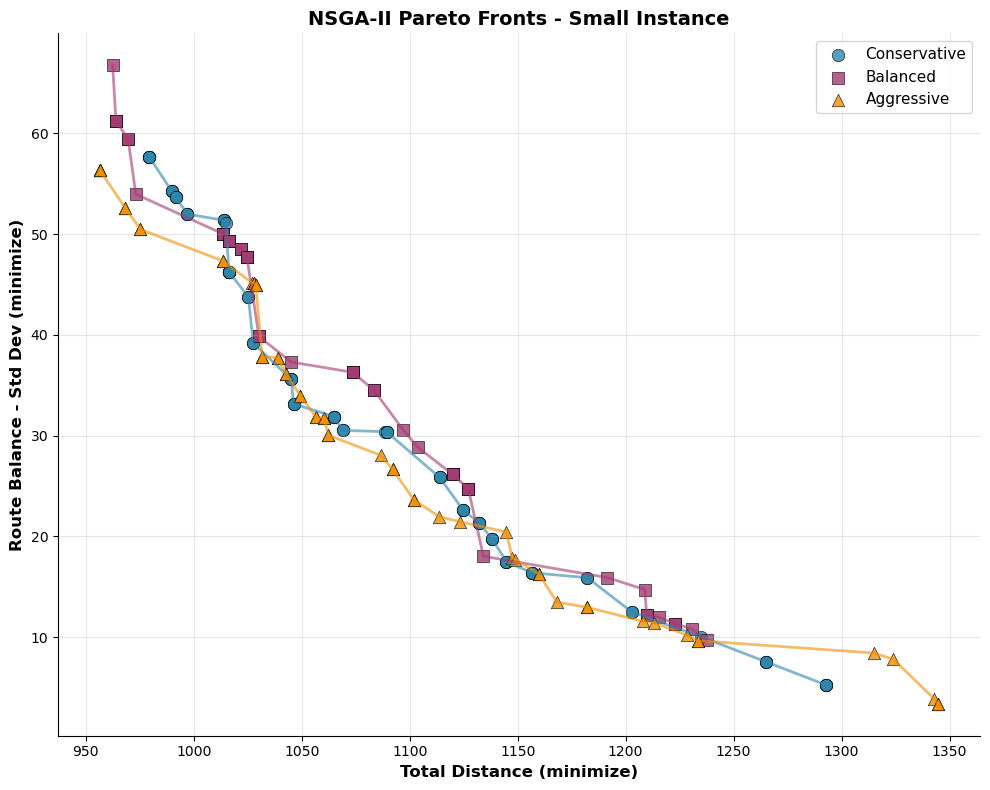

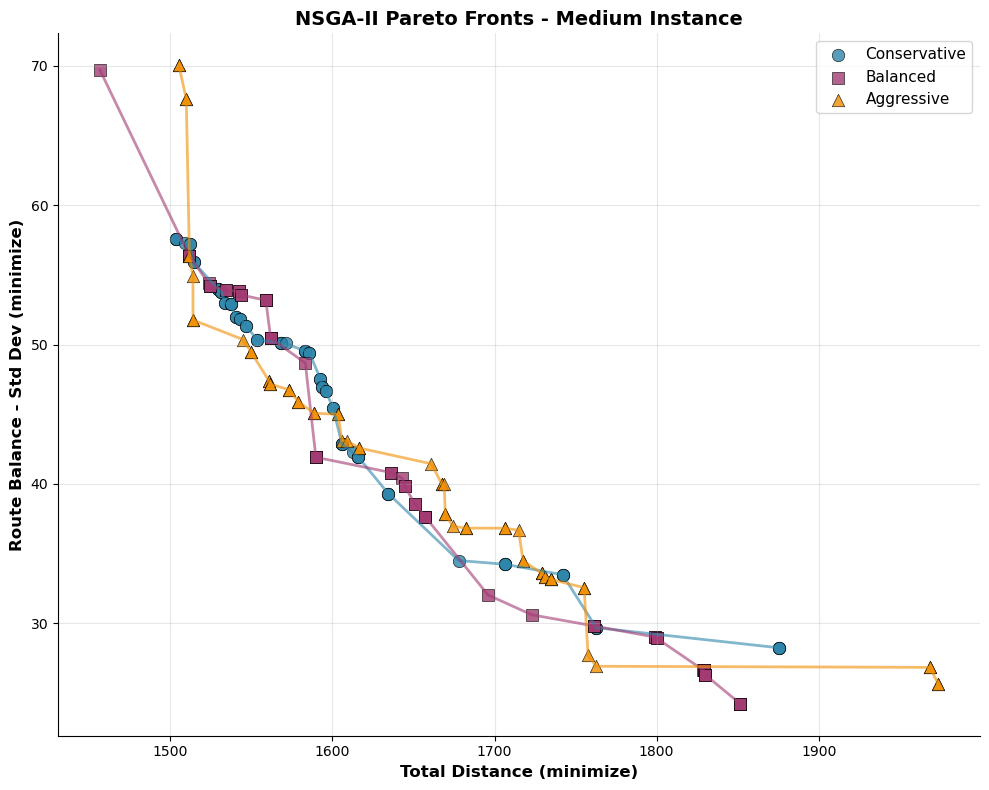

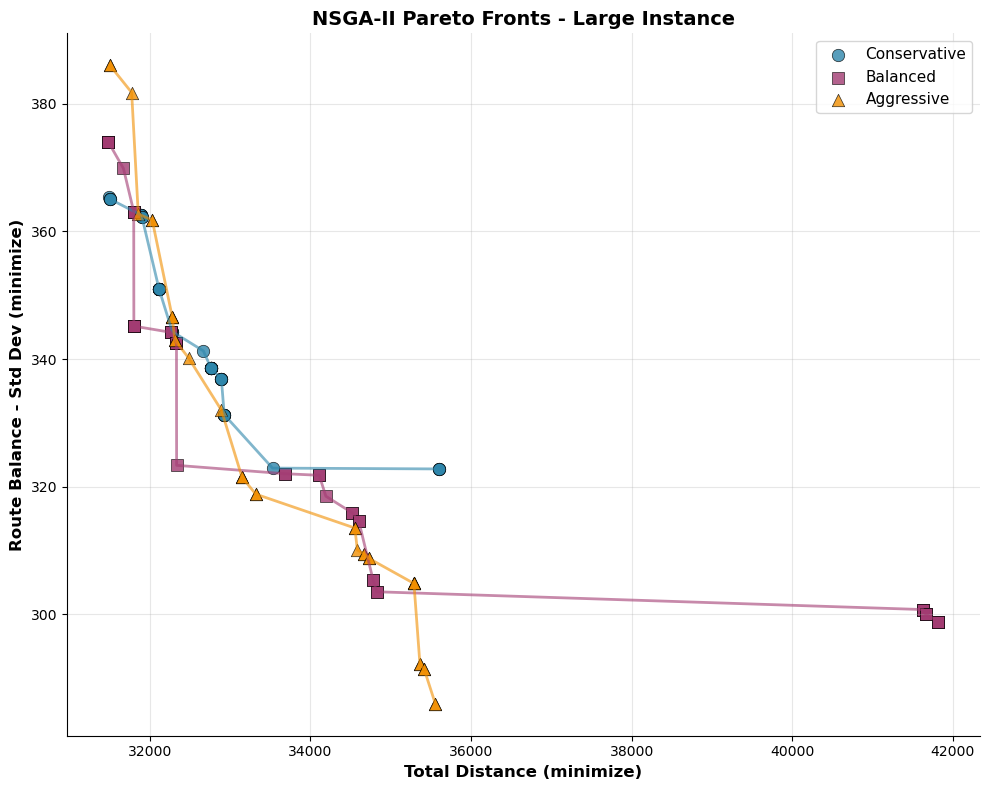

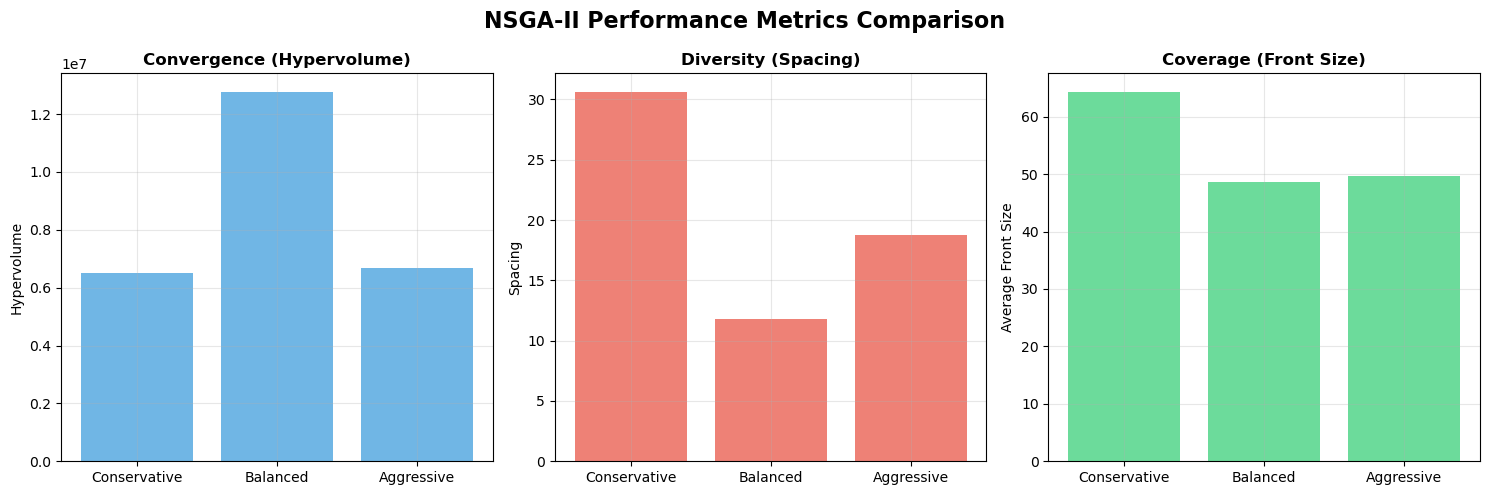


Experiment completed successfully!
Results saved to 'nsga2_clean_results.csv'


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import numpy as np

def calculate_metrics(pareto_front):
      """Fixed metrics calculation with better error handling"""
      if not pareto_front or len(pareto_front) < 2:
          return 0, 0, len(pareto_front) if pareto_front else 0

      obj1 = [ind['objectives'][0] for ind in pareto_front]
      obj2 = [ind['objectives'][1] for ind in pareto_front]

      # Hypervolume (convergence metric)
      ref_point = [max(obj1) * 1.1, max(obj2) * 1.1]
      hypervolume = sum((ref_point[0] - o1) * (ref_point[1] - o2) for o1, o2 in zip(obj1, obj2))

      # Fixed Spacing calculation (diversity metric)
      if len(pareto_front) < 3:
          spacing = 0  # Need at least 3 points for meaningful spacing
      else:
          distances = []
          for i, ind1 in enumerate(pareto_front):
              min_dist = float('inf')
              for j, ind2 in enumerate(pareto_front):
                  if i != j:
                      dist = ((ind1['objectives'][0] - ind2['objectives'][0])**2 +
                             (ind1['objectives'][1] - ind2['objectives'][1])**2)**0.5
                      min_dist = min(min_dist, dist)
              if min_dist != float('inf'):
                  distances.append(min_dist)

          spacing = np.std(distances) if len(distances) > 1 else 0

      return hypervolume, spacing, len(pareto_front)

def run_focused_experiment(moea_classes, instance_files, param_sets, num_runs=5):
      """Focused experiment for clean results"""
      print("FOCUSED NSGA-II EXPERIMENT - Clean Results")
      print("=" * 60)

      results = []
      pareto_fronts = {}

      for algo_name, algo_class in moea_classes:
          for param_idx, params in enumerate(param_sets, 1):
              param_name = params["name"]
              print(f"\nParameter Set: {param_name}")

              for inst_name, inst_file in instance_files:
                  print(f"  Instance: {inst_name}...", end=" ")

                  all_run_solutions = []
                  run_times = []

                  for run in range(1, num_runs + 1):
                      try:
                          random.seed(run * 456)
                          np.random.seed(run * 456)

                          data = parse_vrp_file(inst_file)
                          nsga = algo_class(
                              data=data,
                              pop_size=params['pop_size'],
                              generations=params['generations'],
                              crossover_rate=params['crossover_rate'],
                              mutation_rate=params['mutation_rate']
                          )

                          start_time = time.time()
                          final_population = nsga.run()
                          elapsed = time.time() - start_time
                          run_times.append(elapsed)

                          pareto_front = [ind for ind in final_population if ind.get('rank') == 1]
                          all_run_solutions.extend(pareto_front)

                      except Exception as e:
                          print(f"Error in run {run}: {e}")
                          continue

                  # Combine solutions and find true Pareto front
                  if all_run_solutions:
                      temp_nsga = NSGAII(data=data, pop_size=10, generations=1)
                      temp_nsga.fast_non_dominated_sort(all_run_solutions)

                      combined_front = [sol for sol in all_run_solutions if sol.get('rank') == 1]
                      combined_front.sort(key=lambda x: x['objectives'][0])

                      key = f"{inst_name}_{param_name}"
                      pareto_fronts[key] = combined_front

                      # Calculate metrics
                      hypervolume, spacing, front_size = calculate_metrics(combined_front)

                      if combined_front:
                          best_distance = min(ind['objectives'][0] for ind in combined_front)
                          best_balance = min(ind['objectives'][1] for ind in combined_front)

                          results.append({
                              'Instance': inst_name,
                              'Parameter_Set': param_name,
                              'Pareto_Front_Size': front_size,
                              'Best_Distance': best_distance,
                              'Best_Balance': best_balance,
                              'Hypervolume': hypervolume,
                              'Spacing': spacing,
                              'Avg_Time': np.mean(run_times) if run_times else 0,
                              'Evaluations': params['pop_size'] * params['generations']
                          })

                      print(f"Complete - {front_size} solutions")
                  else:
                      print("Failed")

      return results, pareto_fronts
def print_results_by_instance(results):
      """Display results organized by instance for better readability"""
      instances = sorted(set(r['Instance'] for r in results))

      for instance in instances:
          instance_results = [r for r in results if r['Instance'] == instance]

          print(f"\n{instance} Instance Results")
          print("=" * 80)

          header = f"{'Parameter':<12} {'PF Size':<8} {'Best Dist':<10} {'Best Balance':<12} " \
                   f"{'Hypervolume':<12} {'Spacing':<10} {'Time(s)':<8}"
          print(header)
          print("-" * 80)

          for result in instance_results:
              spacing_str = f"{result['Spacing']:.3f}" if result['Spacing'] > 0 else "N/A"
              print(f"{result['Parameter_Set']:<12} {result['Pareto_Front_Size']:<8} "
                    f"{result['Best_Distance']:<10.1f} {result['Best_Balance']:<12.2f} "
                    f"{result['Hypervolume']:<12.0f} {spacing_str:<10} {result['Avg_Time']:<8.1f}")

def print_summary_table(results):
      """Print overall summary table"""
      print(f"\nOverall Summary - NSGA-II Results")
      print("=" * 100)

      header = f"{'Instance':<8} {'Parameter':<12} {'PF Size':<8} {'Best Dist':<10} {'Best Balance':<12} " \
               f"{'Hypervolume':<12} {'Spacing':<10} {'Time(s)':<8}"
      print(header)
      print("-" * 100)

      for result in results:
          spacing_str = f"{result['Spacing']:.3f}" if result['Spacing'] > 0 else "N/A"
          print(f"{result['Instance']:<8} {result['Parameter_Set']:<12} {result['Pareto_Front_Size']:<8} "
                f"{result['Best_Distance']:<10.1f} {result['Best_Balance']:<12.2f} "
                f"{result['Hypervolume']:<12.0f} {spacing_str:<10} {result['Avg_Time']:<8.1f}")

      print("-" * 100)
      print("Notes: PF Size = Pareto Front Size, Spacing = N/A when < 3 solutions")

def plot_pareto_fronts(pareto_fronts):
      """Clean Pareto front visualization - one plot per instance"""
      if not pareto_fronts:
          print("No Pareto fronts to plot")
          return

      colors = {'Conservative': '#2E86AB', 'Balanced': '#A23B72', 'Aggressive': '#F18F01'}
      markers = {'Conservative': 'o', 'Balanced': 's', 'Aggressive': '^'}
      instances = ['Small', 'Medium', 'Large']

      # Create separate figure for each instance
      for instance in instances:
          instance_fronts = {k: v for k, v in pareto_fronts.items() if k.startswith(instance)}

          if not instance_fronts:
              continue

          plt.figure(figsize=(10, 8))

          for key, front in instance_fronts.items():
              if front:
                  _, param_name = key.split('_', 1)
                  obj1 = np.array([ind['objectives'][0] for ind in front])
                  obj2 = np.array([ind['objectives'][1] for ind in front])

                  # Sort for smooth lines
                  sorted_idx = np.argsort(obj1)
                  obj1_sorted = obj1[sorted_idx]
                  obj2_sorted = obj2[sorted_idx]

                  # Plot with clear styling
                  plt.scatter(obj1, obj2, c=colors[param_name], marker=markers[param_name],
                             s=80, alpha=0.8, label=param_name,
                             edgecolors='black', linewidth=0.5)

                  # Connecting line
                  plt.plot(obj1_sorted, obj2_sorted, color=colors[param_name],
                          alpha=0.6, linewidth=2, linestyle='-')

          plt.xlabel("Total Distance (minimize)", fontsize=12, fontweight='bold')
          plt.ylabel("Route Balance - Std Dev (minimize)", fontsize=12, fontweight='bold')
          plt.title(f"NSGA-II Pareto Fronts - {instance} Instance", fontsize=14, fontweight='bold')
          plt.legend(fontsize=11)
          plt.grid(True, alpha=0.3)

          # Clean styling
          ax = plt.gca()
          ax.spines['top'].set_visible(False)
          ax.spines['right'].set_visible(False)

          plt.tight_layout()
          plt.show()

def plot_metrics_comparison(pareto_fronts):
      """Separate metrics comparison plot"""
      if not pareto_fronts:
          return

      # Calculate metrics by parameter set
      param_metrics = {}
      for key, front in pareto_fronts.items():
          if front:
              _, param_name = key.split('_', 1)
              if param_name not in param_metrics:
                  param_metrics[param_name] = {'hv': [], 'spacing': [], 'size': []}

              hv, spacing, size = calculate_metrics(front)
              param_metrics[param_name]['hv'].append(hv)
              param_metrics[param_name]['spacing'].append(spacing if spacing > 0 else 0)
              param_metrics[param_name]['size'].append(size)

      param_names = list(param_metrics.keys())
      avg_hv = [np.mean(param_metrics[p]['hv']) for p in param_names]
      avg_spacing = [np.mean(param_metrics[p]['spacing']) for p in param_names]
      avg_size = [np.mean(param_metrics[p]['size']) for p in param_names]

      # Create metrics comparison plot
      fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

      # Hypervolume
      ax1.bar(param_names, avg_hv, color='#3498DB', alpha=0.7)
      ax1.set_title("Convergence (Hypervolume)", fontweight='bold')
      ax1.set_ylabel("Hypervolume")
      ax1.grid(True, alpha=0.3)

      # Spacing
      ax2.bar(param_names, avg_spacing, color='#E74C3C', alpha=0.7)
      ax2.set_title("Diversity (Spacing)", fontweight='bold')
      ax2.set_ylabel("Spacing")
      ax2.grid(True, alpha=0.3)

      # Front size
      ax3.bar(param_names, avg_size, color='#2ECC71', alpha=0.7)
      ax3.set_title("Coverage (Front Size)", fontweight='bold')
      ax3.set_ylabel("Average Front Size")
      ax3.grid(True, alpha=0.3)

      plt.suptitle("NSGA-II Performance Metrics Comparison", fontsize=16, fontweight='bold')
      plt.tight_layout()
      plt.show()

  # Experiment configuration
print("Clean NSGA-II Experiment - Assignment 2 Focus")

moea_classes = [("NSGAII", NSGAII)]

instance_files = [
      ("Small", "data/small.vrp"),
      ("Medium", "data/medium.vrp"),
      ("Large", "data/large.vrp"),
  ]

param_sets = [
      {"name": "Conservative", "pop_size": 40, "generations": 30, "crossover_rate": 0.8, "mutation_rate": 0.1},
      {"name": "Balanced", "pop_size": 35, "generations": 35, "crossover_rate": 0.7, "mutation_rate": 0.15},
      {"name": "Aggressive", "pop_size": 30, "generations": 40, "crossover_rate": 0.6, "mutation_rate": 0.2}
  ]

  # Run experiment
results, pareto_fronts = run_focused_experiment(moea_classes, instance_files, param_sets, num_runs=5)

  # Display results - one table at a time
print_results_by_instance(results)
print_summary_table(results)

  # Display plots - one at a time
plot_pareto_fronts(pareto_fronts)
plot_metrics_comparison(pareto_fronts)

  # Save results
df = pd.DataFrame(results)
df.to_csv('nsga2_clean_results.csv', index=False)

print("\nExperiment completed successfully!")
print("Results saved to 'nsga2_clean_results.csv'")